# 75% Balanced Consensus: BERT-Based Financial Sentiment Classifier

This document provides an explanation of the python script used to train a classifier on top of a BERT model via fine-tuning. The task is financial sentiment analysis, where sentences are classified into three sentiments: negative, neutral, and positive.

## Dataset

The dataset is [hosted on Hugging Face,](https://huggingface.co/datasets/financial_phrasebank) where you can find further information on its curation, motivation, and annotation.

### Overview

The dataset consists of 4846 lines, each containing a financial text sentence and its corresponding sentiment, separated by an '@' symbol. The sentiment can belong to one of three categories: Negative, Neutral, or Positive, and is distributed as:

- Neutral: 2879 entries (59%)
- Positive: 1363 entries (28%)
- Negative: 604 entries (12.4%)

### Data Fields

- **sentence**: A tokenized line from the dataset.
- **label**: A label representing the sentence class as a string: 'positive', 'negative', or 'neutral'.

### Data Splits

Although the dataset does not come with predefined training/validation/test splits, the sentences are categorized into different configurations based on the degree of agreement among the annotators:

- **sentences_50agree**: Number of instances with >= 50% annotator agreement - 4846 sentences
- **sentences_66agree**: Number of instances with >= 66% annotator agreement - 4217 sentences
- **sentences_75agree**: Number of instances with >= 75% annotator agreement - 3453 sentences
- **sentences_allagree**: Number of instances with 100% annotator agreement - 2264 sentences

For this project, we use the `sentences_50agree` configuration comprising of 4846 instances and manually split it into training, validation, and testing sets in a 70-15-15 proportion.

All sentences in the dataset are limited to fewer than 512 tokens, in accordance with the BERT model's input constraints.

## Imports and System Setup

The first part of the code includes importing necessary modules and setting up the TensorFlow environment to recognize accessible GPU devices.


## Metrics

The model's performance after training is evaluated based on accuracy and F1 score. Accuracy measures the proportion of correct predictions, while the F1 score provides a harmonic mean between precision and recall, hammered down for individual classes.

F1 score is calculated after each epoch by a custom F1_Evaluation class that uses the Scikit-learn function `f1_score()` for calculation.

We took the extra step of tracking the F1 score for the validation set for a few reasons due to using a financial dataset:

- **Handling Imbalance**: Financial datasets often exhibit class imbalance. For instance, genuine transactions significantly outnumber fraudulent ones. Accuracy can be misleading in such cases, making F1 a more balanced metric as it considers both precision and recall.

- **Balancing Costs**: Both false negatives (e.g., overlooking a negative sentiment) and false positives (e.g., misclassifying a neutral statement as negative) have implications. The F1 score ensures a balance between reducing these two error types.

- **Threshold Tuning**: Financial decisions can involve adjustable thresholds. The F1 score can guide optimization, ensuring neither precision nor recall is neglected.

## Wandb

[Wandb (Weights & Biases)](https://wandb.ai/site) is used for experiment tracking.

## Preprocessing

The data is read from the .txt file. The file encoding is first detected using the `chardet` library, and then the data is loaded into a pandas DataFrame using the detected encoding. The DataFrame contains two columns: sentence and label.

Then the data is split into train, validation, and test sets, stratifying on the label to respect the original distribution of classes in the dataset.

The `BertTokenizer` is used to encode the sentences into format suitable for the BERT model. `truncation=True` and `padding=True` ensures that all sequences are of the same length.

The tokenized sentence encodings and the corresponding labels are wrapped into TensorFlow's `Dataset` objects.

## Model Creation

The existing BERT model ('bert-base-uncased') from HuggingFace's transformer models is loaded for sequence classification with 3 labels (negative, neutral, positive).

## Model Compilation and Training

The model is compiled with Adam optimizer, `SparseCategoricalCrossentropy` loss function, and accuracy as a metric. We use `SparseCategoricalCrossentropy` as this is a  multi-class classification with integer labels (not one-hot encoded). It's memory-efficient, especially for many classes, and pairs with a softmax activation in the model's output.

A Wandb run is initialized, and the data is fit on the model using a batch size of 8 for 10 epochs. The validation data and the custom F1 score calculation callback are also passed in the fit method.

## Evaluation

The model is evaluated on the test set. Classification report and F1 score are printed to show detailed information about performance on all three categories. The F1 score is also logged to the Wandb run.

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=abfffe0e4cad90ca763be92540fab6f2ad961f9dbbb9828c02db7ff69a3d1ed1
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00


In [3]:
# Easy place to track what we're training
WHICH_DATASET = 'Sentences_75Agree.txt'
WHICH_RUN_NAME = 'bert-balanced-75Agree-20'
seed_val = 42

# Import necessary libraries
import os

# Used to suppress output for F1 validation calculation
import io
import contextlib

# For encoding detection
import chardet

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Hugging Face Transformers for BERT
from transformers import BertTokenizer, TFBertForSequenceClassification

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Ensure we have a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verify current GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Weights and Biases for tracking experiments
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import f1_score

Num GPUs Available:  1
Found GPU at: /device:GPU:0


# Prepare Data

## Overview

The varying levels of annotator agreements creates an unusual challenge. The aim is to create a train, test, and validation split that does not bias the model towards obvious sentiments. This guide will describe each step in the data splitting process.

## Step 1: Load the Data

Firstly we load the dataset files (which are text files in this case). Considering the possibility that these text files might have different encodings (they initially crashed the program as they use `ISO-8859-1`), we use Python's `chardet` library to detect the encoding before reading the file. This ensures that the loading of files doesn't fail due to encoding issues. The data is then shuffled randomly. The shuffling was an easy thing to miss, as previously we had used `train_test_split` from `scikit-learn` to split the data, and it had automatically shuffled the data. The data actually comes nearly sorted by sentiment, so without shuffling the model can't be fine-tuned at all.

The files are read in the following way:
- Every sentence in the dataset is separated by an '@' delimiter.
- There are no headers in the files so they are assigned later as ['sentence', 'label'].
- We use pandas' `read_csv` function to read these files.

## Step 2: Create a Subset from 'sentences_50agree'

The `sentences_50agree` dataset is the largest and most diverse dataset. To avoid overfitting and create a diverse validation set, we create a subset from this dataframe that will later be used for validation/testing. This subset is the same size as the train set.

## Step 3: Split the Subset into Validation and Test Sets

The subset created from `sentences_50agree` is split into validation and test sets. Here, a stratified sampling is performed to ensure that the split datasets have instances of each class ('positive', 'negative', and 'neutral') in proportions close to their original distribution in the parent dataset. The dataset is split in such way that 31% data is used for validation/testing. We choose 31% as this seems to result in the closest to a 70/15/15 train/validate/test split once the datasets have been assembled.

## Step 4: Update the Training Set

After obtaining the validation and test sets, we remove sentences present in these sets from the training set. This is done to avoid data leakage and ensure that the model doesn't see any sentence in the training phase that it would later encounter in the validation/testing phase.

## Step 5: Further Divide the Validation and Test Sets

The validation/test set subset is then divided equally into two parts: one part forms the validation set and the other part forms the test set.

## Step 6: Output the Sizes and Percentages

Finally, after creating all the datasets, we output the sizes of the train, validation, and test datasets along with their respective percentages to make sure that the classes are as balanced as they can be given the data.

This completes our data splitting process ensuring that we have a good mix of data in each dataset and our model does not get biased towards the easy-to-identify financial sentiments.

In [4]:
# Load a dataset given its path
def load_data(data_path, seed):
    raw_data = open(data_path, 'rb').read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print("Encoding for:", data_path, "is:", encoding)
    df = pd.read_csv(data_path, delimiter='@', header=None, names=['sentence', 'label'], encoding=encoding)
    return df.sample(frac=1, random_state=seed)

# Load data with correct encoding and delimiter
df_50agree = load_data('Sentences_50Agree.txt', seed_val)
train = load_data(WHICH_DATASET, seed_val)

# Save original count for unit testing purposes
original_50agree_count = train.shape[0]

# Take a random subset of sentences_50agree equal in size to the size of train dataset
subset_50agree = df_50agree.sample(n=len(train), random_state=seed_val)

# Randomly choose 31% of the data from this subset for validation/test
_, valid_test_subset = train_test_split(subset_50agree, test_size=0.31, random_state=seed_val, stratify=subset_50agree['label'])

# Remove items from train dataset that are in the validation/test set
train = train[~train['sentence'].isin(valid_test_subset['sentence'])]

# Split the validation/test set in half into validation and test set
valid, test = train_test_split(valid_test_subset, test_size=0.5, random_state=seed_val, stratify=valid_test_subset['label'])

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert texts to BERT input format
train_encodings = tokenizer(train.sentence.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(valid.sentence.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test.sentence.tolist(), truncation=True, padding=True)

def make_tf_dataset(encodings, labels):
    """Function to convert encodings and labels into tensorflow dataset."""
    input_ids = np.array(encodings['input_ids'])
    attention_mask = np.array(encodings['attention_mask'])
    labels = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels)).map(
        lambda input_ids, attention_mask, labels : ({"input_ids": input_ids, "attention_mask": attention_mask}, labels))

# Defining the labels keys and their respective values as per the model
label2num = {'negative':0,'neutral':1,'positive':2}
train_labels = [label2num[x] for x in train.label.tolist()]
val_labels = [label2num[x] for x in valid.label.tolist()]
test_labels = [label2num[x] for x in test.label.tolist()]

# Convert encodings and labels into tensorflow dataset
train_dataset = make_tf_dataset(train_encodings, train_labels)
val_dataset = make_tf_dataset(val_encodings, val_labels)
test_dataset = make_tf_dataset(test_encodings, test_labels)

# Print the sizes and percentages
total_size = len(train) + len(valid) + len(test)

print("\nSize of Train set:", len(train),
      f"({(len(train)/total_size)*100:.2f}%)")
print("Size of Validation set:", len(valid),
      f"({(len(valid)/total_size)*100:.2f}%)")
print("Size of Test set:", len(test),
      f"({(len(test)/total_size)*100:.2f}%)")

Encoding for: Sentences_50Agree.txt is: ISO-8859-1
Encoding for: Sentences_75Agree.txt is: ISO-8859-1



Size of Train set: 2710 (71.67%)
Size of Validation set: 535 (14.15%)
Size of Test set: 536 (14.18%)


# Check out the distribution of the classes to ensure they look balanced across datasets

In [5]:
# Distribution in the Training set
print("Training set:")
print(train['label'].value_counts())

# Distribution in the Validation set
print("\nValidation set:")
print(valid['label'].value_counts())

# Distribution in the Test set
print("\nTest set:")
print(test['label'].value_counts())

Training set:
neutral     1682
positive     704
negative     324
Name: label, dtype: int64

Validation set:
neutral     319
positive    148
negative     68
Name: label, dtype: int64

Test set:
neutral     319
positive    149
negative     68
Name: label, dtype: int64


# F1 Callback to track F1 Validation

In [6]:
# Custom callback for F1 evaluation at the end of each epoch
class F1_Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(F1_Evaluation, self).__init__()
        self.interval = interval
        self.dataset = validation_data
        self.X_val, self.y_val = [], []

        # Iterating over the dataset to get batches
        for batch in self.dataset:
            # Batch consists of inputs and labels
            inputs, labels = batch
            self.X_val.append(inputs)  # inputs is a dict with keys ['input_ids', 'attention_mask']
            self.y_val.append(np.atleast_1d(np.squeeze(labels.numpy())))  # Converting labels tensor to numpy array

        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        """Method called at the end of each epoch, calculating and logging F1 score."""
        print("\nCalculating validation F1 score...")
        # Process only for epochs with (epoch number modulo self.interval) equal to 0
        if epoch % self.interval == 0:
            y_pred = []

            # Iterate over inputs for each batch to generate predictions
            for X_val_batch in self.X_val:
                # Redirect stdout and stderr to avoid print statements inside keras.model.predict
                with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                    y_pred_single = self.model.predict(X_val_batch).logits
                # Softmax on logits and take class with maximum probability
                y_pred_single = tf.nn.softmax(y_pred_single).numpy().argmax(axis=-1)
                # Ensure that y_pred_single is at least a 1D array even if it is a scalar
                y_pred.append(np.atleast_1d(y_pred_single))

            # Concatenate all predictions and labels
            y_pred = np.concatenate(y_pred)
            y_val = np.concatenate(self.y_val)

            # Calculate F1 score and append to F1 scores list
            _f1 = f1_score(y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)

            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))

             # Log the validation F1 score at the end of each epoch
            wandb.log({"val_f1_score": _f1})

In [7]:
# Log in to W&B account for experiment tracking
wandb.login()

# Load pre-trained BERT model with a classification layer on top
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define loss function, optimizer, and metrics
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# optimizer = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Initializing wandb run
wandb.init(project="bert-sentiment", name=WHICH_RUN_NAME)

# Prepare for F1 score evaluation
val_dataset_temp = val_dataset.batch(8)
f1_evaluation = F1_Evaluation(validation_data=val_dataset_temp, interval=1)

# Add early stopping (disabled for now)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset.batch(8),
    validation_data=val_dataset_temp,
    epochs=20,
    callbacks=[WandbCallback(save_model=False), f1_evaluation] #, early_stopping]
)

# Evaluate the model with test dataset and show the classification report
y_test = test.label.map(label2num).values
y_pred = tf.nn.softmax(model.predict(test_dataset.batch(8)).logits).numpy().argmax(axis=-1)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
test_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Test F1 Score:", test_f1_score)

# Log the test F1 score to wandb (single data point)
wandb.log({'test_f1_score': test_f1_score})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: iankelk. Use `wandb login --relogin` to force relogin


Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.8583
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.8556
339/339 [==============================] - 99s 150ms/step - loss: 0.3902 - accuracy: 0.8583 - val_loss: 0.4296 - val_accuracy: 0.8561
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9587
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.8314
339/339 [==============================] - 26s 77ms/step - loss: 0.1213 - accuracy: 0.9587 - val_loss: 0.6813 - val_accuracy: 0.8280
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9790
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.8572
339/339 [==============================] - 26s 76ms/step - loss: 0.0729 - accuracy: 0.9790 - val_loss: 0.5200 - val_accuracy: 0.8579
Epoch 4/20
339/339 [==============================] - ETA: 0s - loss: 0.041

# Plot the training

In [8]:
def plot_training_process(history, f1_scores):
    fig, axs = plt.subplots(2, 2, figsize=(18, 8),
                            gridspec_kw={'height_ratios': [2, 1]})

    # Collapse the subplots for the F1 scores into a single subplot
    axs[1, 0].remove()
    axs[1, 1].remove()

    # Plotting training and validation loss
    axs[0, 0].plot(history.history["loss"], label='Train')
    axs[0, 0].plot(history.history["val_loss"], label='Validation')
    axs[0, 0].set_title("Model Loss")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].legend()

    # Plotting training and validation accuracy
    axs[0, 1].plot(history.history["accuracy"], label='Train')
    if "val_accuracy" in history.history:
        axs[0, 1].plot(history.history["val_accuracy"], label='Validation')
    axs[0, 1].set_title("Model Accuracy")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].legend()

    # Plotting Validation F1 Scores
    ax2 = fig.add_subplot(2, 1, 2)  # 2x1, occupying the second slot.
    ax2.plot(f1_scores)
    ax2.set_title("Validation F1 Score")
    ax2.set_ylabel("F1 Score")
    ax2.set_xlabel("Epoch")
    ax2.legend(["F1 Score"], loc="upper left")

    # Improve layout and show plots
    plt.subplots_adjust(hspace=0.6)
    plt.show()

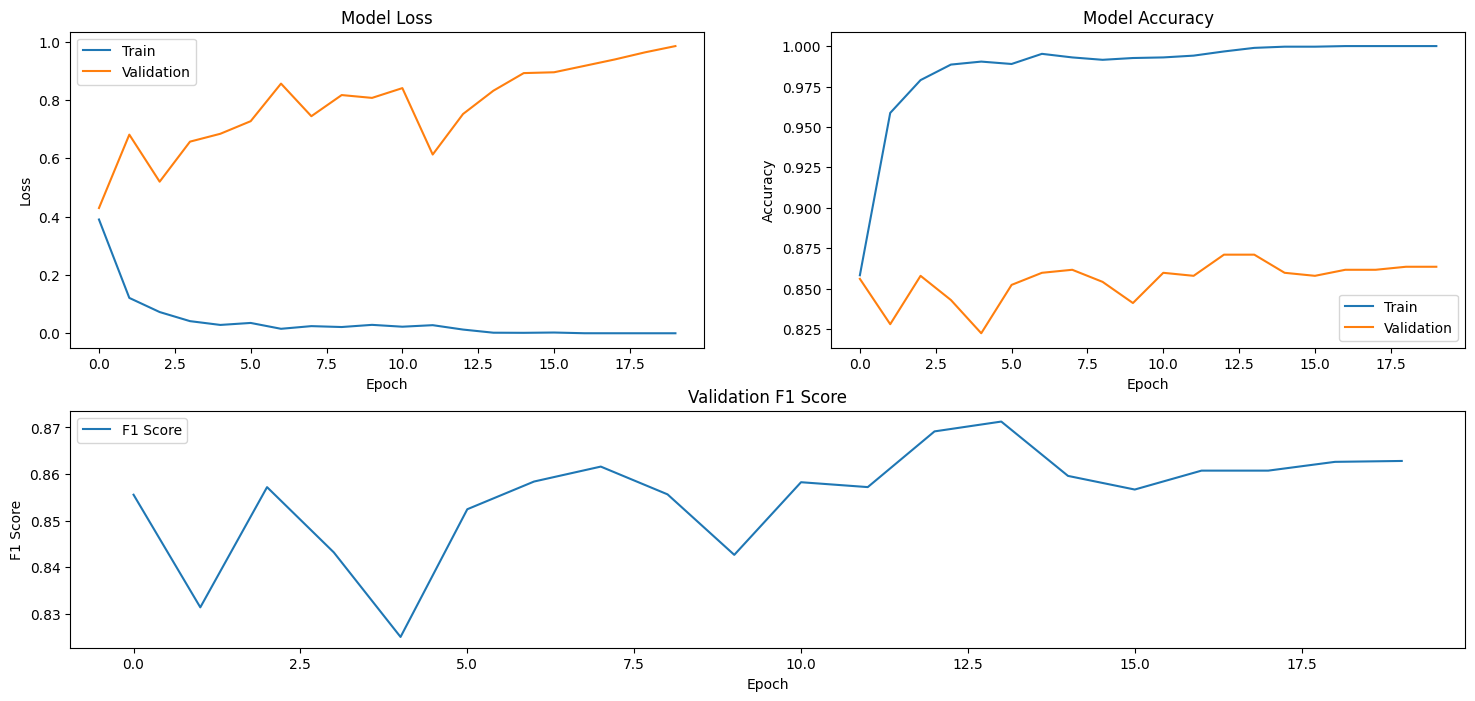

In [9]:
plot_training_process(history, f1_evaluation.f1_scores)